In [75]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init
import numpy as np
import importlib
import torch.optim as optim

import kagglehub
import data
import agente


importlib.reload(data)
importlib.reload(agente)

<module 'agente' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\agente.py'>

In [90]:
#Aqui habría que poner la linea de codigo para descargar el dataset
#El dataset tiene un par de fotos en los que el formato del nombre de la imagen esta mal; yo las he borrado directamente pero en google colab no se puedem borrar archivos
#por eso no he puesto el codigo de la descarga
#Cuando hagas pruebas tu carga el dataset entero en dataset = data.ImgDataset(utk_ruta,transform=transform) y cuando los tengas cargados quita las foto de dataset que den problemas
#Son aquellas que eran de la forma edad_año_fecha.jpg


In [76]:
#solo sirve en mi ordena ichi esta linea
utk_ruta = "C:\\Users\\Adrian\\.cache\\kagglehub\\datasets\\jangedoo\\utkface-new\\versions\\1\\UTKFace"

# Transformar dataset 
Transformamos las imagenes en una estructura de datos con la que podamos trabajar

In [77]:
#Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Esto normalizara las imagenes
dataset = data.ImgDataset(utk_ruta,transform=transform) #Pasamos las imagenes a la estructura de datos

GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negrata','Chinito','Indio','Otros')


In [78]:
# Crear los DataLoaders
train_dataloader,test_dataloader = data.entrenamientoTest(dataset=dataset,test_size=0.2,batch_size=4)

print(len(train_dataloader))
print(len(test_dataloader))

4741
1186


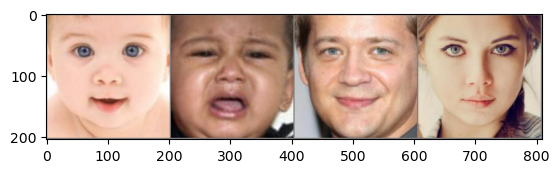

Edad:     1.0   1.0  30.0  18.0
Genero: Hombre Mujer Hombre Mujer
Raza:   Blanco Indio Blanco Blanco


In [79]:
# Display image and label.
imagenes, edades,generos,razas = next(iter(train_dataloader))

# show images
data.mostrarImg(imagenes)
print('Edad:  ',' '.join('%5s' % edades[j].item() for j in range(4)))
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
print('Raza:  ',' '.join('%5s' % RAZA[razas[j].item()] for j in range(4)))


# Modelo 1: Denzel Washington

Entrenaremos 3 modelos distintos, uno por cada objetivo que queremos predecir. 

Ambos modelos tendrán la misma estructura excepto en la ultima capa. 

Además el entrenamiento será distinto para cada uno de ellos pues utilizaremos distintos criterios y optimizadores segun el objetivo

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenzelWashington(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
       
        self.fc1 = nn.Linear(12 * 11 * 11, 500)
        self.fcout = nn.Linear(500, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) #3 fotos 100x100
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fcout(x)
        return x




In [81]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cuda


Creamos un agente con los 3 modelos siguientes:

In [83]:
#Modelo edad
DWEdad = DenzelWashington(output_layers=1).to(device)
mseLoss = nn.MSELoss()

#Modelo Genero
DWGenero = DenzelWashington(output_layers=2).to(device)
entropyLossGen = nn.CrossEntropyLoss()

#Modelo raza
DWRaza = DenzelWashington(output_layers=5).to(device)
entropyLossRaza = nn.CrossEntropyLoss()

agenteDW = agente.Agente(modeloEdad=DWEdad,
                         modeloGenero=DWGenero,
                         modeloRaza=DWRaza,
                         criterioEdad=mseLoss,
                         criterioGenero=entropyLossGen,
                         criterioRaza=entropyLossRaza,
                         device=device,
                         epochs=150,
                         lr = 0.0001)


In [ ]:
#Entrenamos el agente
agenteDW.entrenarAgente(train_data=train_dataloader)

torch.save(agenteDW.modeloEdad.state_dict(), './DWEdad.pth')
torch.save(agenteDW.modeloGenero.state_dict(), './DWGenero.pth')
torch.save(agenteDW.modeloRaza.state_dict(), './DWRaza.pth')

torch.Size([4, 3, 200, 200])
torch.cuda.FloatTensor


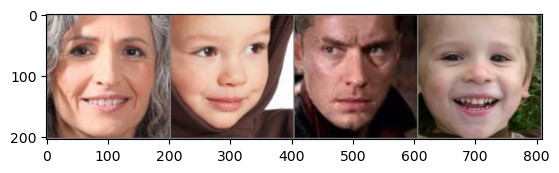

Valor real
Genero: Mujer Hombre Hombre Hombre
Predicciones
Genero: Mujer Hombre Hombre Mujer


In [48]:
#Pruebas
imagenes, _,genero,_ = next(iter(test_dataloader))
imagenes = imagenes.to(device)
print(imagenes.shape)
print(imagenes.type())
predicciones = DWGenero(imagenes)
_ , predicciones = torch.max(predicciones, 1)


data.mostrarImg(imagenes)
print("Valor real")
print('Genero:',' '.join('%5s' % GENERO[genero[j].item()] for j in range(4)))
print("Predicciones")
print('Genero:',' '.join('%5s' % GENERO[predicciones[j].item()] for j in range(4)))


In [62]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch in test_dataloader:
        imagenes,edades,generos,razas = batch
        imagenes, generos = imagenes.to(device),generos.to(device)

        
        predicciones = DWGenero(imagenes)
        
        _, generosPred = torch.max(predicciones, 1)
        total += generosPred.size(0)
        correct += (generosPred == generos).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 4742 test images: 89 %


In [50]:
#Pruebas tempus fugit

# Ejemplo de uso
data.convertirRedimensionar('./fotos/adri.png', './fotos/24_0_0_adri.jpg')
data.convertirRedimensionar('./fotos/ichi.png', './fotos/23_1_0_ichi.jpg')
data.convertirRedimensionar('./fotos/luis.png', './fotos/24_0_0_luis.jpg')




torch.Size([3, 3, 200, 200])
torch.cuda.FloatTensor
torch.Size([3])


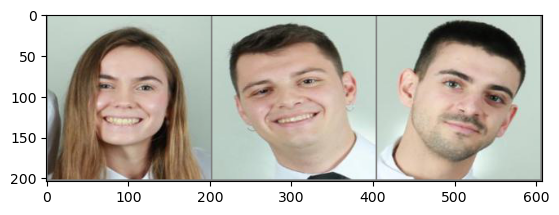

Valor real
Genero: Mujer Hombre Hombre
Predicciones
Genero: Mujer Hombre Hombre


In [52]:
tempusFugit = data.ImgDataset("./fotos",transform=transform)
imagenes = [imagen for imagen, _, _,_ in tempusFugit ]
generos = [genero for _,_, genero,_ in tempusFugit]

imagenes = torch.stack(imagenes,dim = 0)
generos = torch.stack(generos,dim=0)

imagenes = imagenes.to(device)
print(imagenes.shape)
print(imagenes.type())
print(generos.shape)

data.mostrarImg(imagenes)
predicciones = DWGenero(imagenes)    
_, generosPred = torch.max(predicciones, 1)

print("Valor real")
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(3)))
print("Predicciones")
print('Genero:',' '.join('%5s' % GENERO[generosPred[j].item()] for j in range(3)))
